In [1]:
import requests

In [2]:
html = requests.get("https://www.opentable.com/state-of-industry").text
    

In [3]:
from bs4 import BeautifulSoup

In [4]:
soup = BeautifulSoup(html)
scripts = soup.find_all(name="script")
charts = [s for s in scripts if "covidDataCenter" in s.text]
assert len(charts) == 1
chart = charts[0].text
type(chart)

str

In [5]:
text = 'covidDataCenter":'
i = chart.find(text)
raw = chart[i + len(text):]
j = raw.find(";")
print(j)
raw = raw[:j - 1]
print(len(raw))

44937
44936


In [6]:
import json
data = json.loads(raw)

In [7]:
dates = data["headers"]
city_data = {d["name"]: d["yoy"] for d in data["cities"]}

In [8]:
dates[0]

'2/18'

In [9]:
from datetime import datetime, timedelta
datetimes = [datetime(2020, *map(int, x.split("/"))) for x in dates]

In [10]:
import pandas as pd
df = pd.DataFrame(city_data)
df.head()

,Atlanta,Austin,Baltimore,Boston,Calgary,Charlotte,Chicago,Cincinnati,Ciudad de México,Columbus,...,San Antonio,San Diego,San Francisco,San Pedro Garza García,Scottsdale,Seattle,Tampa,Toronto,Vancouver,Washington
0,6,0,10,5,0,1,-7,7,-8,-10,...,-6,-1,-15,-9,-3,8,7,-14,9,-5
1,9,-6,42,15,4,-3,-3,1,-9,0,...,-4,9,-11,-12,-3,11,5,-8,1,57
2,-5,2,12,-3,5,-27,-5,-6,-2,-3,...,-5,7,-4,-5,5,6,2,-9,7,9
3,-5,3,-9,-12,0,-1,-4,-6,-3,-6,...,2,-1,-8,4,6,1,-4,-9,6,0
4,-3,2,12,-2,11,0,7,-8,0,-8,...,-6,-12,-9,10,-5,1,11,-4,7,9


In [11]:
df.to_csv("data/open-table-cities.csv", index=False)

In [12]:
df.columns

Index(['Atlanta', 'Austin', 'Baltimore', 'Boston', 'Calgary', 'Charlotte',
       'Chicago', 'Cincinnati', 'Ciudad de México', 'Columbus', 'Dallas',
       'Denver', 'Dublin', 'Edmonton', 'Fort Lauderdale', 'Hamburg',
       'Honolulu', 'Houston', 'Indianapolis', 'Las Vegas', 'London',
       'Los Angeles', 'Louisville', 'Miami', 'Miami Beach', 'Minneapolis',
       'Montréal', 'München', 'Naples', 'Nashville', 'New Orleans', 'New York',
       'Orlando', 'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland',
       'Raleigh', 'San Antonio', 'San Diego', 'San Francisco',
       'San Pedro Garza García', 'Scottsdale', 'Seattle', 'Tampa', 'Toronto',
       'Vancouver', 'Washington'],
      dtype='object')

In [13]:
n_restaurants = {d["name"]: int(d["size"]) for d in data["cities"] if int(d["size"]) >= 200}
pd.Series(n_restaurants).sort_values()

Atlanta             200
Boston              200
Dallas              200
Denver              200
Houston             200
Las Vegas           200
Los Angeles         200
Philadelphia        200
San Diego           200
San Francisco       200
Washington          200
Chicago             300
Ciudad de México    300
New York            600
London              700
dtype: int64

In [14]:
to_show = [
#     "Chicago",
#     "Vancouver",
    "Ciudad de México",
    "London",
    "Seattle",
    "New York",
#     "Washington",
]

In [15]:
show = df[to_show].copy()

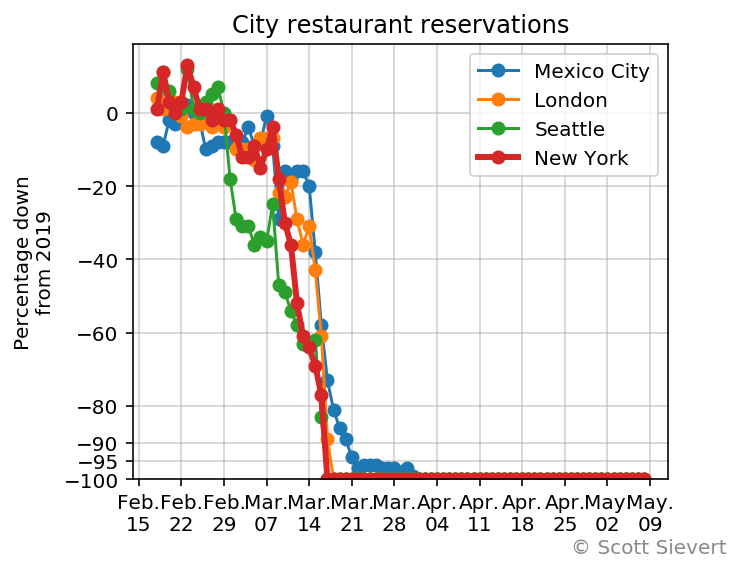

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
w = 4
fig, ax = plt.subplots(figsize=(1.2 * w, w))

for city in show:
    label = city
    if "xico" in label:
        label = "Mexico City"
    kwargs = {}
    if city == "New York":
        kwargs = {"linewidth": 3}
    ax.plot(datetimes, show[city], "o-", label=label, **kwargs)

ticks = (-np.arange(5) * 20).tolist()
ticks.extend([-90, -95, -100, 20])
ax.yaxis.set_major_locator(plt.FixedLocator(ticks))
weeks = pd.date_range(datetime(2020, 2, 15), datetime.now() + timedelta(7), freq="7D")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b.\n%d"))
ax.xaxis.set_major_locator(plt.FixedLocator([mdates.date2num(w) for w in weeks]))
ax.grid(alpha=0.6)
ax.legend(loc="best")
ax.set_ylabel("Percentage down\nfrom 2019")
ax.set_title("Cities")
ax.set_ylim(-100, None)
xlim = ax.get_xlim()
ax.text(xlim[1] - 16, -120, "© Scott Sievert", color="#" + "8" * 6)
ax.set_title("City restaurant reservations")
fig.savefig("imgs/opentable-cities.svg", bbox_inches="tight")
fig.savefig("imgs/opentable-cities.png", bbox_inches="tight", dpi=300)